In [7]:
import scipy.io as sio
import matplotlib.pyplot as plt
from matplotlib import cm as cm
import numpy as np
import time as tm
import random as rand

# Loading network data
mat = sio.loadmat('AlgorithmOutput/optimalNetwork.mat')
W = mat['A_norm_max_inh'].astype(float)
N = len(W)
V = np.load('Connectome/V_weights.npy').flatten()

# seed for random number generation
seed = 2000
np.random.seed(seed)
rand.seed(seed)


# simulate dynamics function
def simulation(time, V, W, external_input):
    X = np.zeros([N, time + 1])
    X[:, 0] = np.random.rand(N) * 2 - 1
    for t in range(0, time):
        X[:, t + 1] = np.tanh(V * external_input[t] + np.dot(W, X[:, t]))
    return X

# plot information
def plot(X,inputt):
    fig2 = plt.figure(figsize=(15,10),dpi=300)
    fig2.patch.set_facecolor('xkcd:white')

    ax4 = plt.subplot2grid((10,1), (0,0), colspan=1, rowspan=1)
    cax4 = plt.xlim(0,time)
    fig2.text(0.5,0.9,'Input',color='black',fontsize=25,ha="center", va="bottom")

    ax4.set_facecolor('xkcd:white')
    ax4.tick_params(axis=('x'), colors='white')
    ax4.tick_params(axis=('y'), colors='white')
    ax4.set_yticklabels([])
    ax4.set_xticklabels([])

    for spine in ax4.spines.values():
        spine.set_edgecolor('white')

    plt.plot(np.arange(0,time),inputt,color='black')

    ax6 = plt.subplot2grid((10,1), (2,0), colspan=1, rowspan=2)
    cax6 = plt.xlim(0,time)
    fig2.text(0.5,0.75,'Neuron '+str(neuron_chosen),color='black',fontsize=25,ha="center", va="bottom")
    ax6.set_facecolor('xkcd:white')
    ax6.tick_params(axis=('x'), colors='black')
    ax6.tick_params(axis=('y'), colors='black')
    plt.plot(np.reshape(np.arange(0,time),(time,1)),np.transpose(X[neuron_chosen,:-1]),color='black',linewidth=2)
    plt.xlabel('Time',fontsize=25)
    ax6.xaxis.label.set_color('black')
    ax6.tick_params(labelsize=15)
    plt.ylim(-1,1)

    ax6.spines['top'].set_color('white'); ax6.spines['right'].set_color('white')
    ax6.spines['bottom'].set_color('white'); ax6.spines['left'].set_color('white')

    ax5 = plt.subplot2grid((10,1), (5,0), colspan=1, rowspan=6)
    cax5 = plt.imshow(X,cmap='jet',aspect='auto')
    color_bar = plt.colorbar(orientation='horizontal',drawedges=False)
    color_bar.outline.set_edgecolor('white')
    color_bar.ax.tick_params(labelsize=15,color='black')
    cbytick_obj = plt.getp(color_bar.ax.axes, 'xticklabels')
    plt.setp(cbytick_obj, color='black')
    plt.clim(-1,1)
    ax5.set_yticklabels([])
    ax5.set_facecolor('xkcd:white')
    ax5.tick_params(axis=('x'), colors='black')
    ax5.tick_params(axis=('y'), colors='black')
    plt.ylabel('Neurons',fontsize=25)
    ax5.xaxis.label.set_color('black')
    ax5.yaxis.label.set_color('black')
    ax5.tick_params(color='white',labelsize=15)

    for spine in ax5.spines.values():
        spine.set_edgecolor('white')
        

# apply inhibition randomly
def random_inhibition(A, n):
    newA = np.abs(np.copy(A))
    inhi_pos = rand.sample(range(0, len(A)), n)
    for i in inhi_pos:
        newA[i, :] = -newA[i, :]
    return newA, inhi_pos


# check applied inhibition
def check_inhibition(A):
    sumA = np.sum(A, 1)
    return sum(sumA < 0)

In [9]:
# parameters
time = 500
pulses_amount = 20  # pulses
wid = 0.01  # histogram width
duration = 8  # pulse duration
t0 = 15  # time before first pulse
t = 10  # time for 0 state
std = 2  # variation for pulses length in range [-2,2]
neuron_chosen = 200

# generate input
input_pulses = np.zeros(t0)
pulseirr_number = np.zeros(t0)
number = 1
while len(input_pulses) < time:
    suplementary = rand.randrange(-std, std, 1)
    input_pulses = np.append(input_pulses, np.ones(duration + suplementary))
    input_pulses = np.append(input_pulses, np.zeros(t))
    pulseirr_number = np.append(pulseirr_number, np.zeros(duration + suplementary))
    pulseirr_number = np.append(pulseirr_number, number * np.ones(t))
    number = number + 1

if len(input_pulses) > time:
    aux = time - len(input_pulses)
    input_pulses = input_pulses[:aux]
elif len(input_pulses) < time:
    aux = time - len(input_pulses)
    input_pulses = np.append(input_pulses, np.zeros(aux))

# computing dynamics for intraseries
iterations = 526
response_intraseries = np.zeros([pulses_amount, t, iterations])
out_pulsesirr = np.zeros((N, time + 1, iterations))


for j in range(0, iterations):
    out_pulsesirr[:, :, j] = simulation(time, V, W, input_pulses)

    for z in range(1, pulses_amount + 1):
        indexes = np.where(pulseirr_number == z)[0] + 1
        response_intraseries[z - 1, :, j] = out_pulsesirr[neuron_chosen, indexes, j]

# computing dynamics for interseries
iterations = 100
response_interseries = np.zeros([iterations, t, pulses_amount])
for j in range(0, iterations):
    out_pulsesirr = simulation(time, V, W, input_pulses)
    for p in range(0, pulses_amount):
        indexes = np.where(pulseirr_number == p + 1)[0] + 1
        response_interseries[j, :, p] = out_pulsesirr[neuron_chosen, indexes]

# normalizing intraseries dynamics
for i in range(response_intraseries.shape[2]):
    for j in range(response_intraseries.shape[0]):
        signal = response_intraseries[j, :, i]
        signal = (signal - np.mean(signal)) / np.std(signal)
        response_intraseries[j, :, i] = signal

# computing correlations for intraseries
intraseries_corr = []
for i in range(response_intraseries.shape[2]):
    corr_mat = np.triu(np.corrcoef(response_intraseries[:, :, i]), 1).flatten()
    index = np.where(corr_mat == 0)
    corr_vec = np.delete(corr_mat, index).tolist()
    intraseries_corr = intraseries_corr + corr_vec
intraseries_corr = np.asarray(intraseries_corr)

#normalizing dynamics and computing correlations for interseries
interseries_corr = []
for p in range(response_interseries.shape[2]):
    npmean = np.mean(response_interseries[:, :, p],1).reshape(response_interseries[:, :, p].shape[0], 1)
    npstd = np.std(response_interseries[:, :, p], 1).reshape(response_interseries[:, :, p].shape[0], 1)
    norm_interseries = (response_interseries[:, :, p] - npmean) / npstd
    corr_mat = np.triu(np.corrcoef(norm_interseries), 1).flatten()
    index = np.where(corr_mat == 0)
    interseries_corr = interseries_corr + np.delete(corr_mat, index).tolist()

# uncomment to save data for Visualizing Final Figuryes
# np.savetxt("ProgrammingFigures/fig5_intraseries_corr.csv", intraseries_corr, delimiter=",")
# np.savetxt("ProgrammingFigures/fig5_interseries_corr.csv", interseries_corr, delimiter=",")

(0, 1)

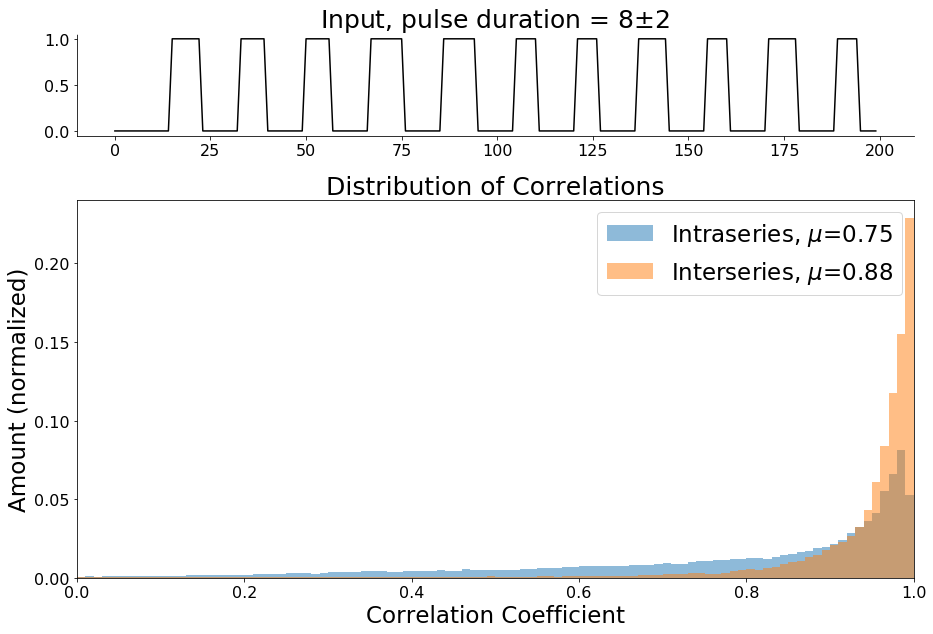

In [10]:
# computing distributions
response_intra_distribution, bins_intra = np.histogram(intraseries_corr, bins=np.arange(-1, 1 + wid, wid))
response_inter_distribution, bins_inter = np.histogram(interseries_corr, bins=np.arange(-1, 1 + wid, wid))
response_intra_distribution = response_intra_distribution / np.sum(response_intra_distribution)
response_inter_distribution = response_inter_distribution / np.sum(response_inter_distribution)

# showing distributions
fig1 = plt.figure(figsize=(15, 10))
ax2 = plt.subplot2grid((10, 1), (0, 0), colspan=1, rowspan=2)
input_external = plt.plot(input_pulses[:200], color='black')
plt.title('Input, pulse duration = ' + str(duration) + '$\pm' + str(std) + '$', fontsize=25)
ax2.spines['top'].set_color('w') 
ax2.spines['right'].set_color('w')
ax2.xaxis.set_tick_params(labelsize=16)
ax2.yaxis.set_tick_params(labelsize=16)
ax1 = plt.subplot2grid((10, 1), (3, 0), colspan=1, rowspan=7)
bar_intra = plt.bar(bins_intra[:-1] + np.diff(bins_intra) / 2, response_intra_distribution, alpha=0.5, width=wid) 
bar_inter = plt.bar(bins_inter[:-1] + np.diff(bins_inter) / 2, response_inter_distribution, alpha=0.5, width=wid)
ax1.tick_params(axis=('x'))
ax1.tick_params(axis=('y'))
ax1.xaxis.set_tick_params(labelsize=16)
ax1.yaxis.set_tick_params(labelsize=16)
mean_intra = np.mean(intraseries_corr)
mean_inter = np.mean(interseries_corr)
leg = plt.legend([bar_intra, bar_inter], ['Intraseries, $\mu$=' + str(round(mean_intra, 3)), 'Interseries, $\mu$=' + str(round(mean_inter, 2))], fontsize=23)
plt.title('Distribution of Correlations', fontsize=25)
plt.ylabel('Amount (normalized)', fontsize=23)
plt.xlabel('Correlation Coefficient', fontsize=23)
plt.xlim((0, 1))

(0, 1)

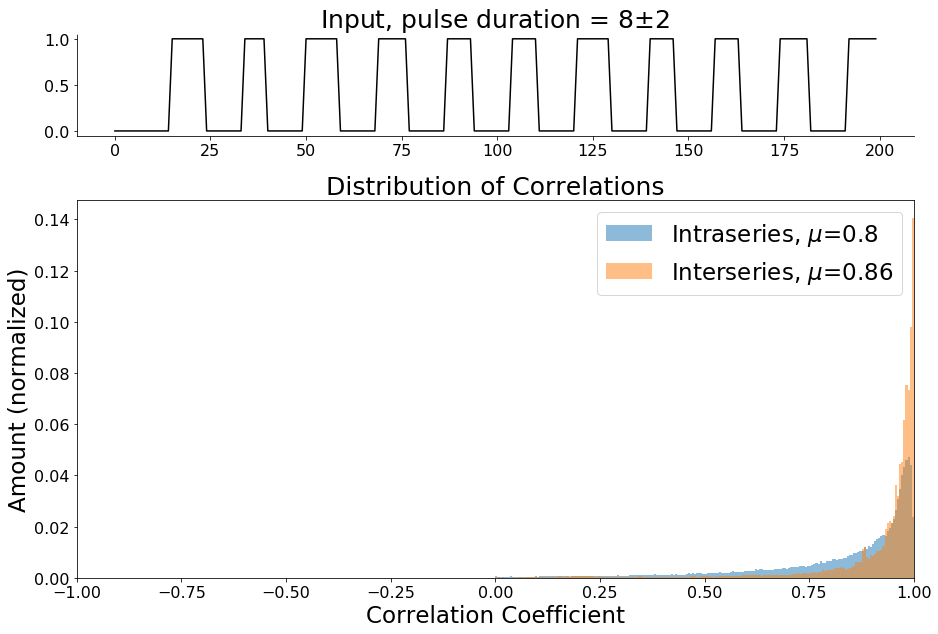

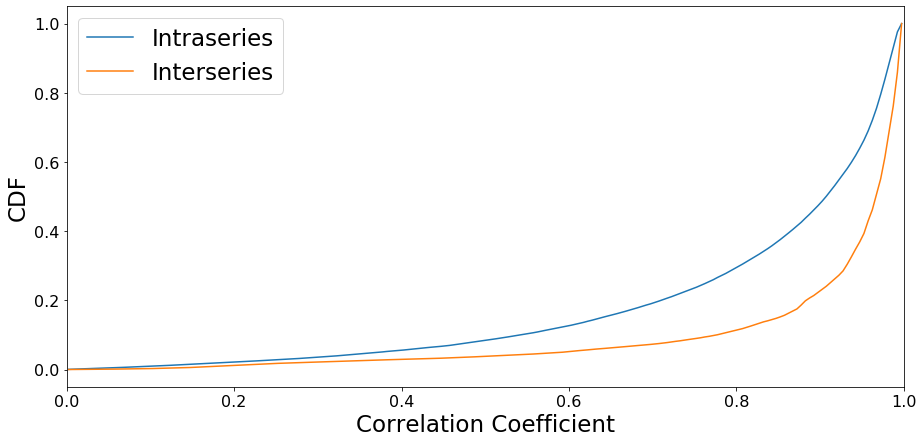

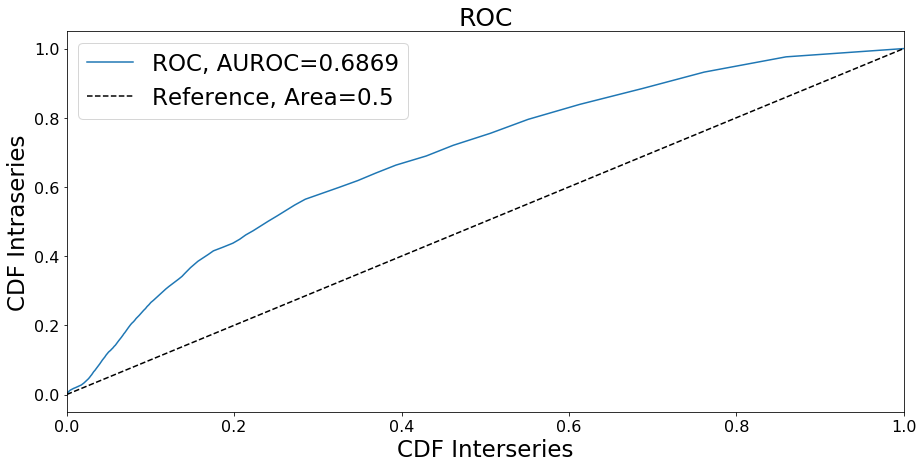

In [4]:
# computing distributions
intraseries_corr_abs = [i for i in intraseries_corr if i > 0]
interseries_corr_abs = [i for i in interseries_corr if i > 0]

[response_intra_distribution,bins_intra] = np.histogram(intraseries_corr_abs, bins=np.arange(0, 1 + wid, wid))
[response_inter_distribution,bins_inter] = np.histogram(interseries_corr_abs, bins=np.arange(0, 1 + wid, wid))

response_intra_distribution = response_intra_distribution / np.sum(response_intra_distribution)
response_inter_distribution = response_inter_distribution / np.sum(response_inter_distribution)

# computing cummulative distributions
CDF_intra = np.cumsum(response_intra_distribution)
CDF_inter = np.cumsum(response_inter_distribution)

# uncomment to save data for figure visualization
# np.savetxt("CDF_intra.csv", CDF_intra, delimiter=",")
# np.savetxt("CDF_inter.csv", CDF_inter, delimiter=",")
# np.savetxt("binsCDF.csv", bins_intra, delimiter=",")
# np.savetxt("ProgrammingFigures/intraseries_corr.csv", intraseries_corr, delimiter=",")
# np.savetxt("ProgrammingFigures/interseries_corr.csv", interseries_corr, delimiter=",")

#computing AUROC
AUROC = np.trapz(CDF_intra, CDF_inter)
AUref = np.trapz([0, 1],[0, 1])

fig1 = plt.figure(figsize=(15, 7))
ax3 = fig1.add_subplot(111)
cdf_intra = plt.plot(bins_intra[:-1] + np.diff(bins_intra) / 2, CDF_intra, label='Intraseries')
cdf_inter = plt.plot(bins_intra[:-1] + np.diff(bins_intra) / 2, CDF_inter, label='Interseries')
ax3.tick_params(axis=('x'))
ax3.tick_params(axis=('y'))
ax3.xaxis.set_tick_params(labelsize=16)
ax3.yaxis.set_tick_params(labelsize=16)
leg = plt.legend(fontsize=23)
plt.ylabel('CDF', fontsize=23)
plt.xlabel('Correlation Coefficient', fontsize=23)
plt.xlim((0, 1))

fig1 = plt.figure(figsize=(15, 7))
ax4 = fig1.add_subplot(111)
ROC = plt.plot(CDF_inter, CDF_intra, label='ROC, AUROC=' + str(round(AUROC, 4)))
cdf_inter = plt.plot([0, 1], [0, 1], 'k--', label='Reference, Area=' + str(round(AUref, 4)))
ax4.tick_params(axis=('x'))
ax4.tick_params(axis=('y'))
ax4.xaxis.set_tick_params(labelsize=16)
ax4.yaxis.set_tick_params(labelsize=16)
leg = plt.legend(fontsize=23)
plt.title('ROC', fontsize=25)
plt.ylabel('CDF Intraseries', fontsize=23)
plt.xlabel('CDF Interseries', fontsize=23)
plt.xlim((0, 1))

